In [3]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
import sklearn.datasets

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

## Опрос в начале лекции
https://goo.gl/forms/LygelSozHCGIo3tF2

## План лекции
- повторение: композиции алгоритмов
- градиентный бустинг
- алгоритм Фридмана
- практические замечания по градиентному бустингу
- Bias-Variance tradeoff
- домашнее задание
- вопросы

##  Идея
Получить сильный алгоритм при помощи усреднения слабых.
В `adaboost` параметры плохо интерпретируются.

Появлялся ряд алгоритмов в смежных статистических задачах:
- GLMBoost
- GAMBoost
- CoxBoost
- *Boost

## Теоретическое обоснование:
$$f(x) == argmin_f{E[L(f(x), y)]}$$

Параметризуем функцию $f(x) = f(x, \theta)$

## Упражнение.

Зачем параметризуем функцию?

Задача сводится к подбору параметров функции: $$\hat{\theta} = argmin_\theta E[L(f(x, \theta), y)]$$

$$L_\theta(\hat{\theta}) = \sum_i L(f(x_i, \hat{\theta}), y_i)$$
$$\hat{\theta} = \sum_i^{num\_iter}{\hat{\theta_i}}$$

Теперь остается оптимизировать функцию потерь при помощи градиентного спуска:
алгоритм:  


Начальное приближение $\hat{\theta} = \hat{\theta}_0$
for i in range(num_iter):  
---- $\hat{\theta} = \hat{\theta} - \nabla L_\theta(\hat{\theta})$  
return $\hat{\theta}$

Аналогичная идея возможна для функций, на каждой итерации:
$$ \hat{f(x)} = \sum \hat{f_i}(x) $$
Ограничим $f(x)$ некоторым семейством функций $h(x, \theta)$.

Тогда для одной итерации градиентного бустинга:
$$\hat{f}(x) = \sum_{k=0}^{i - 1} \hat{f_i}(x)$$

Будем считать взвешенную сумму с коэффициентом $\rho$

$$(\rho_t, \theta_t) = argmin_{\rho, \theta}{E(L(\hat{f}(x) + \rho * h(x, \theta)))}$$
$$\hat{f_t}(x) = \rho_t * h(x, \theta_t)$$

Так как градиенты в функциональном пространстве вычислительно посчитать сложно, будем минимизировать разницу с посчитанными градиентами функции.

$$r_{it} = -\nabla L_\theta(\hat{f}(x))\ \ \ (1)$$
$$\theta_t = argmin_\theta{\sum_i{(r_{it} - h(x_i, \theta)})^2} \ \ \ (2)$$

$$\rho_t = argmin_\rho{\sum{L(\hat{f}(x_i) + \rho * h(x_i, \theta_t) ,y_i)}}\ \ \ (3)$$ 

### Jerome Friedman GBM algorithm

- выборка $X, y$
- число итераций `num_iter`
- функция потерь $L(f(x), y)$
- семейство базовых алгоритмов $h(x, \theta)$

Алгоритм:
Инициализировать $f_0(x)$
```
for i in range(num_iter):
    посчитать r[i][t] (формула 1)
    h(t, x) -- регрессия на r[i][t] (формула 2)
    найти оптимальный коэффициент rho (формула 3)
    f[t](x) = f[t](x) + rho * h(t, theta)
```

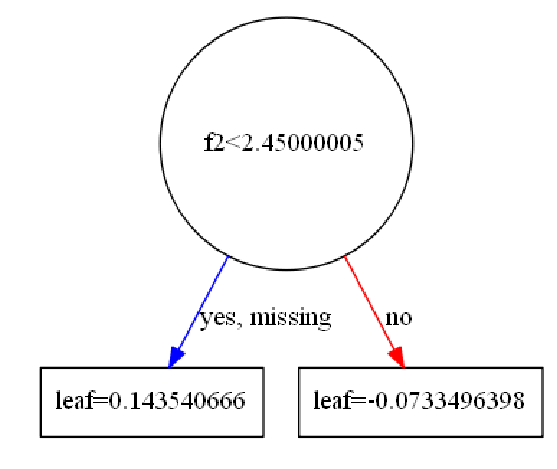

In [4]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt


# load data
dataset = sklearn.datasets.load_iris()
X = dataset.data
y = dataset.target
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot single tree
plot_tree(model)
plt.show()

# Практические замечания по градиентному бустингу

### sklearn

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

n_estimators = 200

X, y = make_hastie_10_2(n_samples=10000)
X_test, y_test = make_hastie_10_2(n_samples=10000)
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X, y)

pred = est.predict(X)
est.predict_proba(X)[0]  # class probabilities

array([0.03525133, 0.96474867])

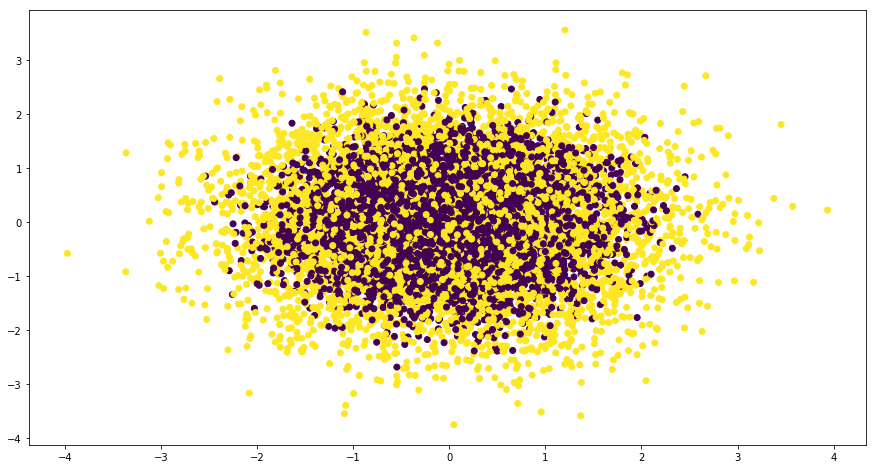

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

As you add more levels, you reduce variance, overfitting trickles in

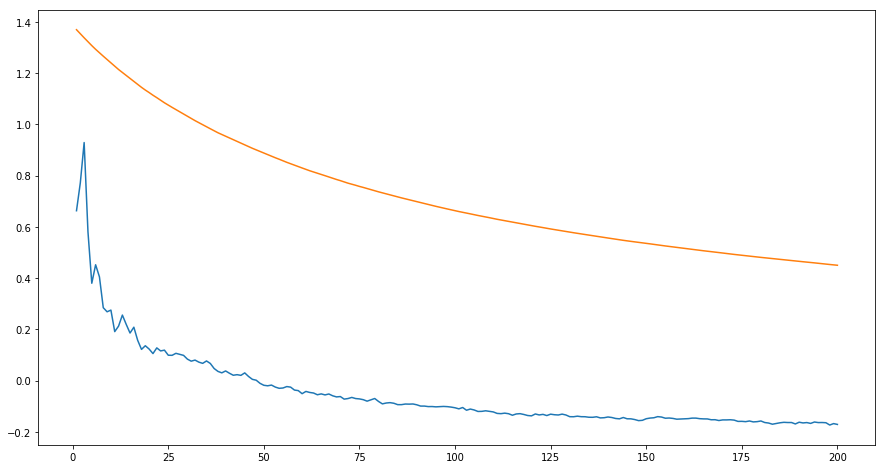

In [7]:
test_score = np.empty(len(est.estimators_))
for i, pred in enumerate(est.staged_predict(X_test)):
    test_score[i] = est.loss_(y_test, pred)
plt.plot(np.arange(n_estimators) + 1, test_score, label='Test')
plt.plot(np.arange(n_estimators) + 1, est.train_score_, label='Train')

# Подбор параметров бустинга
- параметры бустинга (количество базовых алгоритмов, )
- параметры базового алгоритма (например, для решающих деревьев: глубина, критерий)
- параметры задачи (функция потерь, размер выборки, признаки)

booster [default=gbtree] - тип базового алгоритма для бустинга: дерево решений gbtree или линейная модель gblinear.
nthread [default to maximum number of threads available if not set] - число потоков доступных для параллельной работы xgboost.

eta [default=0.3] - темп обучения, перед добавлением дерева в композицию оно умножается на eta. Используется для предотвращения переобучения за счёт "сокращения" весов базовых алгоритмов, делая модель более консервативной. Чем меньше eta, тем больше нужно итераций num_boost_round для обучения модели с хорошим качеством. Диапазон: [0, 1]  
gamma [default=0] - минимальное снижение значения функции потерь, необходимое для дальнейшего разбиения вершины дерева. Большие значения gamma > 0 приводят к более консервативным моделям. Диапазон: [0, $\infty$).  
max_depth [default=6] - максимальная глубина дерева. Диапазон: [1, $\infty$).  
subsample [default=1] - доля выборки, используемая для обучения каждого дерева. Если subsample < 1, то выбирается случайная подвыборка, что помогает в борьбе с переобучением. Диапазон: (0, 1]  
colsample_bytree [default=1] - доля признаков, используемая для обучения каждого дерева. Диапазон: (0, 1]  
lambda [default=1] - коэффициент перед $L_2$-регуляризатором в функции потерь.  
alpha [default=0] - коэффициент перед $L_1$-регуляризатором в функции потерь.  


objective [default=reg:linear] - используемая при обучении функция потерь  


Более подробная информация о параметрах XGBoost-a в https://xgboost.readthedocs.io/en/latest/parameter.html

In [8]:
import time
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

xgb_params1 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 1}
xgb_params2 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 4}
sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in range(n_runs):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, 
                               n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

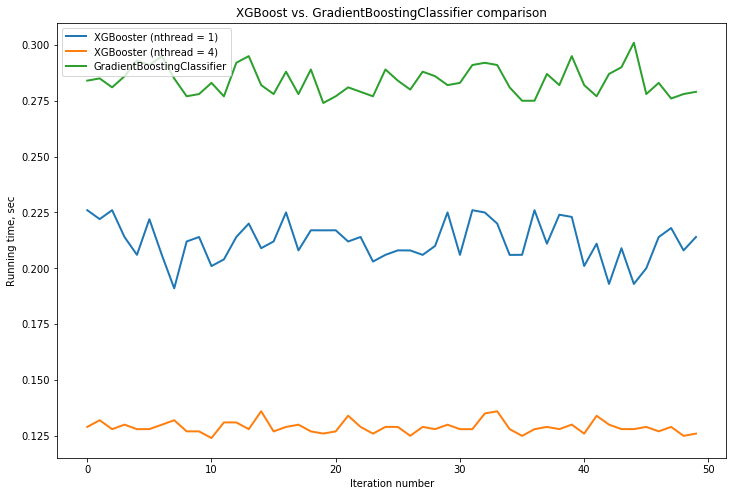

In [9]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

## Bias Variance tradeoff

In [10]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)

In [11]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [12]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0,
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy',
    n_jobs=-1
)

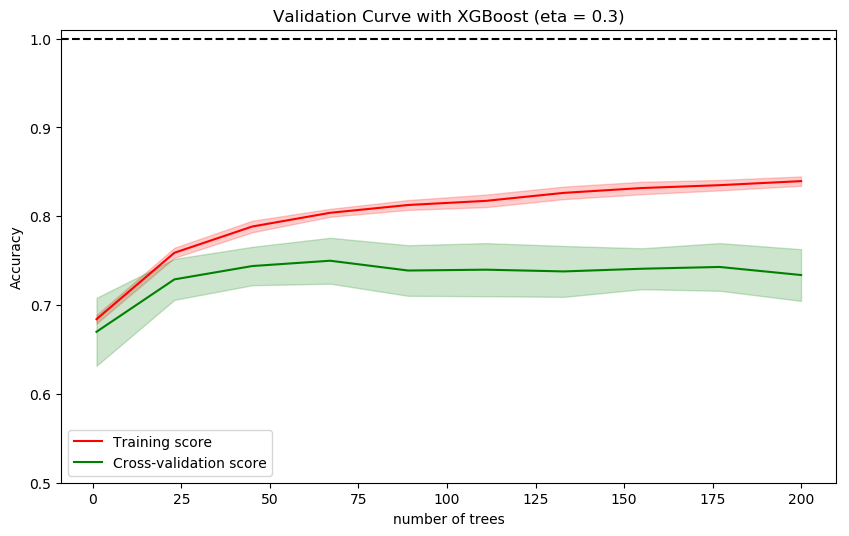

Best cross-validation result (0.75) obtained for 67 trees


In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

### Упражнение.
Какие выводы о работе алгоритма вы можете сделать по этому графику?  
Какое стоит выбрать оптимальное количество деревьев?

### Ответ


1. С некоторого момента алгоритм начинает переобучаться.
2. variance мал при малом количестве деревьев, bias большой.
3. variance стабилен при увеличении сложности модели.

### Упражнение.
Как уменьшить bias (смещение) модели?  
Как уменьшить variance (разброс) модели?

### Ответ
Уменьшение bias:
- усложнять модель (слои нейронной сети, глубина дерева),
- feature engineering

Уменьшение variance:
- сбор датасета,
- feature selection,
- добавление регуляризации

## Библиотеки для градиентного бустинга

- sklearn (don't use)
- xgboost
- catboost (handle cateforical features)
- h2o (http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html)
- https://lightgbm.readthedocs.io/en/latest/

## Задание

В чем отличия Random Forest и градиентного бустинга? Когда какой из алгоритмов стоит применять?

### Опрос в конце занятия:
https://goo.gl/forms/KC7GA5uhVnbAQ41y1

## Дополнительные материалы:

[Boosting playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)  
[Hastie on GBM h2o conference](https://www.youtube.com/watch?v=wPqtzj5VZus)  
[Wiki on gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)  
[Gradient boosting visualization](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)  
[Friedman's article](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)  
[Документация XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html)  

## Фидбек
https://otus.ru/polls/2840/